In [3]:
import Base.Threads
Threads.nthreads()
#packages we need
using DifferentialEquations
using Plots 
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using FileIO
using StatsPlots
using Plots.PlotMeasures
using Statistics
plotly();

In [4]:
using Pkg
Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [fbb218c0] BSON v0.3.6
  [336ed68f] CSV v0.10.8
  [a93c6f00] DataFrames v0.22.7
  [2b5f629d] DiffEqBase v6.84.0
  [0c46a032] DifferentialEquations v6.20.0
  [31c24e10] Distributions v0.25.45
  [5789e2e9] FileIO v1.16.0
  [6a86dc24] FiniteDiff v2.17.0
  [28b8d3ca] GR v0.64.4
  [09f84164] HypothesisTests v0.10.11
  [7073ff75] IJulia v1.23.3 `https://github.com/JuliaLang/IJulia.jl.git#master`
  [033835bb] JLD2 v0.4.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b4fcebef] Lasso v0.6.2
  [21d151f5] LassoPlot v1.1.1
  [1dea7af3] OrdinaryDiffEq v5.71.2
  [69de0a69] Parsers v2.2.4
  [58dd65bb] Plotly v0.3.0
  [a03496cd] PlotlyBase v0.5.4
  [f0f68f2c] PlotlyJS v0.14.1
  [91a5bcdd] Plots v1.32.0
  [438e738f] PyCall v1.94.1
  [d330b81b] PyPlot v2.11.0
  [1a8c2f83] Query v1.0.0
  [102930c3] SmoothingSplines v0.3.1
  [f3b207a7] StatsPlots v0.14.34
  [c3572dad] Sundials v4.11.4
  [bd369af6] Tables v1.10.0
  [a759f4b9] TimerOutputs v0.5.22
  [0f1e0344] 

In [5]:
#set up where CSV2Julia is
#from: https://github.com/SiFTW/CSV2JuliaDiffEq
locationOfCSV2Julia="CSV2Julia/csv2model-multiscale.py"

#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/updated_NFkB_reactions.csv"
parametersFile="moduleDefinitionFiles/parameters.csv"
rateLawsFile="moduleDefinitionFiles/rateLaws.csv"
generatedCSVLocation="generatedCSVs/"
distributedModelFilesLocation="distributedModelFiles/"

#make any folders that don't already exist
mkpath(generatedCSVLocation)
mkpath(distributedModelFilesLocation);

In [6]:
#keep this as 1
first_cell=1
#change this if you want more cells
last_cell=1000


#total IKK amount in nM, you probably won't change this.
totalIKK=140
#what percentage of IKK should be active during the steady state? Default = 1% = totalIKK/100
basalIKK=totalIKK/100
#you can use the multiplier to scale the IKK during the simualation
IKKMultiplier=1
#this is just a long time to run the steady-state phase for and shouldn't need changing
maxTimeSS=100000.0
#an 8 hour time course = 60*8, you might need longer for non-canonical simulations.
maxTimeTC=60*8
#this is how different the cells should be from each other. leave this at 11% as it is based on our previous work (https://www.pnas.org/doi/10.1073/pnas.1715639115).
preCV=0.11;

#what colours shall we plot with? :seaborn_colorblind is a nice default palette.
colorArray=palette(:seaborn_colorblind);

In [7]:
#this function creates the dynamic ikk time course curve.
function ikkDefault(t,maxTime)
    #explicitely defined input
    IKKparamVals=[0,85,100,85,45,30,25,23,18,15,12,10,10]./100
    paramTime=[0,5,10,15,18,20,300,400,450,480,500,520,max(maxTime,2880)]
    #get the value after the current time point
    indexGTTime=min(searchsortedfirst(paramTime,t),length(paramTime))
    #get the one before
    indexLTTime=max(1,indexGTTime-1)
    timeGTt=paramTime[indexGTTime]
    timeLTt=paramTime[indexLTTime]
    valGTt=IKKparamVals[indexGTTime]
    valLTt=IKKparamVals[indexLTTime]
    timeDiff=timeGTt-timeLTt
    #if the time before and time after are different do a basic linear interpolation between the two.
    if timeDiff>0
        valDiff=valGTt-valLTt
        gradient=valDiff/timeDiff
        timeStep=t-timeLTt
        return valLTt+(gradient*timeStep)
    else
        return valLTt
    end
end


ikkDefault (generic function with 1 method)

Define some input curves we might use, we don't use all of these.

In [8]:

#define the 4 variables mentioned above.
ikkSS=t->basalIKK

ikkTC=t->basalIKK+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK);
ikkTCLess=t->basalIKK+(ikkDefault(t, maxTimeTC)*(IKKMultiplier/2)*totalIKK);
NIKFuncSS=t->1
NIKFuncTC=t->0

#define the 4 variables mentioned above.
ikkSS1=t->basalIKK
ikkSS5=t->basalIKK.*5
ikkSS7p5=t->basalIKK.*7.5
ikkSS10=t->basalIKK.*10
ikkSS100=t->basalIKK.*100

ikkTC1=t->basalIKK.*1+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC100=t->basalIKK.*100+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)

ikkTCLess=t->basalIKK+(ikkDefault(t, maxTimeTC)*(IKKMultiplier/2)*totalIKK);

NIKFuncSS=t->1
NIKFuncTC=t->0
NIKFuncSS100=t->1/100


p=plot([1:1:maxTimeTC],ikkTC.(1:1:maxTimeTC),label="smooth fit",title="input curve");
xlabel!("time (h)")
ylabel!("active IKK")

In [9]:
parametersDF = DataFrame(CSV.File(parametersFile,types=Dict(:parameter=>String, :value=>String, :distribute=>Int64)))
originalParams=deepcopy(parametersDF)

thisModelName="odeModel.jl"
thisParamFile=parametersFile
arguments=[reactionsFile, thisParamFile, rateLawsFile,thisModelName]
cmd=`python3 $locationOfCSV2Julia $arguments param`

#lets run csv2julia (requires python to be installed)
run(cmd)

include(thisModelName)
mv(thisModelName,"distributedModelFiles/"*thisModelName, force=true)
println("Model generated for all conditions")

param
Running CSV2JuliaDiffEq with parameters dynamically determined by a variable, re-run with the 5th argument set to 'scan' or 'inline'
Opening moduleDefinitionFiles/rateLaws.csv as rate law file
Opening moduleDefinitionFiles/parameters.csv as parameters file
Opening moduleDefinitionFiles/updated_NFkB_reactions.csv as reactions file
Model generated for all conditions


In [12]:
include("runSimulationFingerprint.jl")

runSimulationFingerprint (generic function with 1 method)

# Simulating all the cell populations

In [13]:
#if you just want the basal fingerprint
#maxTimeTC=1
#if you want a time course response
maxTimeTC=8*60

480

In [14]:
# Please note that "RIVA int" ended up being U2932 R2 so the name is misleading.
# in reality these can be called: "U2932 R1", "U2932 R2" and "RIVA int"
# the plotting commands let us change the legend entries to be different from the condition names
conditions=["U2932","RIVA3","RIVA int","patient old graph 2","healthy B cells","HBL1","U2932R1_hiBasal3_ikkOnly","U2932R2_hiBasal3_ikkOnly"]

paramsToChange=[["k1_RelASynth"],["k1_RelASynth"],["k1_RelASynth"],["k1_RelASynth","basal_RelBSynth"],["k1_RelASynth","basal_RelBSynth"],["k1_RelASynth"],["k1_RelASynth","basal_RelBSynth"],["k1_RelASynth","basal_RelBSynth"]]
modifyAmount=[
         [1.0],[0.4],[0.5],[0.5,0.5],[0.2,0.2],[0.6],[2.0,2.75],[1.0,2.75]
     ];
IKKSSArray=[ikkSS,ikkSS,ikkSS,ikkSS,ikkSS,ikkSS,ikkSS100,ikkSS100,ikkSS100,ikkSS100]
IKKTCArray=[ikkTC,ikkTC,ikkTC,ikkTC,ikkTC,ikkTC,ikkTC100,ikkTC100,ikkTC100,ikkTC100]
NIKSSArray=[NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS]
NIKTCArray=[NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS,NIKFuncSS];

println("Summary of conditions being run:")
folder="outputsNew"
show(IOContext(stdout, :limit => false), "text/plain", hcat(conditions,paramsToChange,modifyAmount))


Summary of conditions being run:
8×3 Matrix{Any}:
 "U2932"                     ["k1_RelASynth"]                     [1.0]
 "RIVA3"                     ["k1_RelASynth"]                     [0.4]
 "RIVA int"                  ["k1_RelASynth"]                     [0.5]
 "patient old graph 2"       ["k1_RelASynth", "basal_RelBSynth"]  [0.5, 0.5]
 "healthy B cells"           ["k1_RelASynth", "basal_RelBSynth"]  [0.2, 0.2]
 "HBL1"                      ["k1_RelASynth"]                     [0.6]
 "U2932R1_hiBasal3_ikkOnly"  ["k1_RelASynth", "basal_RelBSynth"]  [2.0, 2.75]
 "U2932R2_hiBasal3_ikkOnly"  ["k1_RelASynth", "basal_RelBSynth"]  [1.0, 2.75]

Run the simulations, this might take ages when you run all the above conditions with 1000 cells:

In [ ]:
runSimulationFingerprint(first_cell,last_cell,conditions,folder,IKKSSArray,IKKTCArray,NIKSSArray,NIKTCArray)

# Now let's plot the fingerprints!?

Let's just test that we can call python code from julia...


In [44]:
using PyPlot   # important!
using PyCall
@pyimport seaborn as sns
@pyimport pandas as pd
@pyimport matplotlib.pyplot as mtplt
@pyimport matplotlib.patches as mpatches
include("variableNames.jl")

101-element Vector{String}:
 "RelA"
 "p50"
 "RelAp50"
 "RelAn"
 "p50n"
 "RelAnp50n"
 "p52"
 "RelAp52"
 "p52n"
 "RelAnp52n"
 "RelB"
 "RelBp52"
 "RelBn"
 ⋮
 "tcRel"
 "p100"
 "p100n"
 "NIK"
 "p100NIK"
 "IkBdNIK"
 "RelAp50IkBdNIK"
 "RelBp50IkBdNIK"
 "RelBp52IkBdNIK"
 "cRelp50IkBdNIK"
 "cRelp52IkBdNIK"
 "RelAp52IkBdNIK"

In [45]:
function StandardiseDataFrame(df)
    df["test"]=(df["test"].-df["test"].mean())./df["test"].std()
    df["test2"] =(df["test2"].-df["test2"].mean())./df["test2"].std()
    return df
end

StandardiseDataFrame (generic function with 1 method)

In [46]:
function StandardiseDataFrameToTimeZero(df,t0DF)
    df["test"]=(df["test"].-t0DF["test"].mean())./t0DF["test"].std()
    df["test2"] =(df["test2"].-t0DF["test2"].mean())./t0DF["test2"].std()
    return df
end

StandardiseDataFrameToTimeZero (generic function with 1 method)

In [62]:
function plotFingersprints(folder, conditions, xSpeciesName, ySpeciesName, colors, time, lastCell,xlim=[-2,3],ylim=[-1.5,2],legendEntries=conditions)
    
    f, ax = mtplt.subplots(1, 1)
    ax.set_xlabel(xSpeciesName)
    ax.set_ylabel(ySpeciesName)
    fig_size = mtplt.rcParams["figure.figsize"]
    fig_size[1] = 20.4
    fig_size[2] = 15.8
    plt.rcParams["figure.figsize"] = fig_size

    colors=hex.(colors)
    numberOfConditions=length(conditions)
    allEntriesDF=pd.DataFrame(columns=["cond","test", "test2"],index=range(1;stop=lastCell*numberOfConditions))
    totalEntries=1
    for conditionIndex in 1:numberOfConditions
        
        #we're actually going to create a python dataframe that we can pass to kdeplot
        plottingDF = pd.DataFrame(columns=["test", "test2"],index=range(1;stop=lastCell))
        allData=DataFrame
        thisCondition=conditions[conditionIndex]
        
        #we need to get the index of each of the species we need to play
        #if the species name ends in a * we'll assume it's replicating an antibnody that can bind any form of the protein in any complex
        if endswith(xSpeciesName,"*")
            speciesShort=xSpeciesName[1:end-1]
            xSpeciesIndex=intersect(findall( x ->occursin(speciesShort,x),syms),findall(x->!startswith(x,"t"),syms))
        elseif endswith(xSpeciesName,"_")
            speciesShort=xSpeciesName[1:end-1]
            xSpeciesIndex=intersect(findall( x ->occursin(speciesShort,x),syms),findall(x->!startswith(x,"t"),syms),findall(x->!endswith(x, "n"),syms))
        else
            xSpeciesIndex=findfirst(x->xSpeciesName==x,syms)
        end
        if endswith(ySpeciesName,"*")
            speciesShort=ySpeciesName[1:end-1]
            ySpeciesIndex=intersect(findall( x ->occursin(speciesShort,x),syms),findall(x->!startswith(x,"t"),syms))
        elseif endswith(ySpeciesName,"_")
            speciesShort=ySpeciesName[1:end-1]
            ySpeciesIndex=intersect(findall( x ->occursin(speciesShort,x),syms),findall(x->!startswith(x,"t"),syms),findall(x->!endswith(x, "n"),syms))            
        else
            ySpeciesIndex=findfirst(x->ySpeciesName==x,syms)
        end
        #Now, go through every cell and get its full time course
        #we'll add the specific time point to the dataframe
        for i in 1:lastCell
            thisCellData=DataFrame(CSV.File(folder*"/sol_"*thisCondition*"_cell_"*string(i)*".csv"))

            xDataAll=thisCellData[xSpeciesIndex,time+1]
            if(length(xDataAll)>1)
                xDataAll=sum(xDataAll,dims=1)[1]
            end
            yDataAll=thisCellData[ySpeciesIndex,time+1]
            if(length(yDataAll)>1)
                yDataAll=sum(yDataAll,dims=1)[1]
            end
            plottingDF.at[i] = [xDataAll,yDataAll]
            allEntriesDF.at[totalEntries]=[thisCondition,xDataAll,yDataAll]
            totalEntries+=1
        end
        #plot the dataframe into a kdeplot
        #,clip=(-5,10)
        #sns.kdeplot(ax=ax[1],data=plottingDF,x="test", y="test2", color="#"*colors[conditionIndex],thresh=0, label=thisCondition, linewidths=1.5, levels=6)
        #ax[1].legend()

    end
    allEntriesDF=StandardiseDataFrame(allEntriesDF)
    patchList=[]
    for conditionIndex in 1:numberOfConditions
        thisCondition=conditions[conditionIndex]
        indexesToUse=allEntriesDF["cond"] == thisCondition
        justIndexes=findall(indexesToUse[:values])[1:end-1]
        thisSubDF=get(allEntriesDF.loc, justIndexes)
        #,clip=(-5,10)
        sns.kdeplot(ax=ax,data=thisSubDF,x="test", y="test2", color="#"*colors[conditionIndex],thresh=0, label=thisCondition, linewidths=1.5, levels=[0.15, 0.3, 0.45, 0.6, 0.75, 0.9],clip=(-3.5,4),cut=0)
        thisEntry=legendEntries[conditionIndex]
        push!(patchList,mpatches.Patch(color="#"*colors[conditionIndex], label=thisEntry))
    end
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(handles=patchList,loc="center left",bbox_to_anchor=(1, 0.5))
    plt.xlim(xlim[1],xlim[2])
    plt.ylim(ylim[1],ylim[2])
    plt.title(string(time))

     #
     #ax[1].ylabel(ySpeciesName)
end

plotFingersprints (generic function with 4 methods)

In [63]:
function plotAllSpeciesNormalised(speciesToPlot,conditionsToPlot,colorArray,first_cell,last_cell,folder,hoursToPlot,ymax)
    for species in speciesToPlot
        #thisPlot=plot(title=species)
        thisPlotStd=plot(title=species*" avg")
        boxPlotAll=plot(title=species*" ss")
        BoxPlotAvg=plot(title=species*"avg ss")
        conditionIndex=1
        meansOfAllConditions=zeros(1,length(conditionsToPlot))
        stdOfAllConditions=zeros(1,length(conditionsToPlot))
        lengthOfTC=0
        for condition in conditionsToPlot
            lengthOfTC=size(DataFrame(CSV.File(folder*"/sol_"*condition*"_cell_1.csv")),2)-1

            conditionArray=zeros(last_cell,lengthOfTC)
            lineColor=colorArray[conditionIndex]
            virtExpFlag=false
            for i in first_cell:last_cell
                thisCellData=DataFrame(CSV.File(folder*"/sol_"*condition*"_cell_"*string(i)*".csv"))
                if !("names" in names(thisCellData))
                    insertcols!(thisCellData, 1, :names=>syms)
                end
                allNoneFloats=findall(eltype.(eachcol(thisCellData)).!=Float64)
                if length(allNoneFloats)>1
                    for index in allNoneFloats[2:end]
                        thisCellData[!,index]=parse.(Float64,thisCellData[:,index])
                    end
                end
                thisTC=zeros(1,size(thisCellData,2)-1)
                if endswith(species,"*")
                    virtExpFlag=true
                    speciesShort=species[1:end-1]
                    speciesIDs=intersect(findall( x ->occursin(speciesShort,x),syms),findall(x->!startswith(x,"t"),syms))
                    speciesNames=String.(syms[speciesIDs])
#                     println("For species: "*species*" printing: ")
#                     println(speciesNames)
                    for thisName in speciesNames
                        thisSpeciesTC=convert(Matrix, thisCellData[thisCellData[!,:names].==thisName,:])[2:end]
                        
                        thisTC=thisTC.+thisSpeciesTC'
                    end
                else
                    thisTC=convert(Matrix, thisCellData[thisCellData[!,:names].==species,:])[2:end]
                end
                conditionArray[i,:]=thisTC[1:lengthOfTC]


            end

            df = DataFrame(Float64.(conditionArray),:auto)
            #add the variable names and save to a file
            #CSV.write("outputs/sol_"*thisCondition*"_cell_"*string(i)*".csv",Tables.columntable(df));
            CSV.write("outputs/allTCs_"*species*"_cell.csv",df);

            
            meanOfCondition=mean(conditionArray, dims=1)
            stdOfCondition=std(conditionArray, dims=1)
#             println(meanOfCondition)
#             println(stdOfCondition)
            plot!(thisPlotStd,meanOfCondition'./meanOfCondition[1],grid=false,color=lineColor,ribbon=stdOfCondition'./meanOfCondition[1],fillalpha=.5,label=condition,linewidth=5)

            meansOfAllConditions[conditionIndex]=meanOfCondition[1]
            stdOfAllConditions[conditionIndex]=stdOfCondition[1]

            conditionIndex+=1
        end
        conditionIndex=1
        #plot!(boxPlotAll,conditionsToPlot, meansOfAllConditions;, c=colorArray, yerr = stdOfAllConditions', label = "",xrotation = 90,seriestype = :scatter,fillcolor=:match)
        for condition in conditionsToPlot
            plot!(boxPlotAll,[conditionIndex], [meansOfAllConditions[conditionIndex]], c=colorArray[conditionIndex], yerr = stdOfAllConditions[conditionIndex], label = false,xrotation = 90,seriestype = :scatter,fillcolor=:match,markersize=20,markerstrokewidth=5)            
            conditionIndex+=1
        end
        plot!(boxPlotAll,xticks = (1:length(conditions), conditions),xlim=(0,length(conditionsToPlot)+1),ylim=(0,maximum([maximum(meansOfAllConditions)+maximum(stdOfAllConditions),10])),dpi=300,size=(800,1000),xtickfontsize=18,ytickfontsize=18)        
        plot!(thisPlotStd,xticks=(collect(0:30:lengthOfTC),collect(0:0.5:lengthOfTC/60)),ylim=(0,ymax),xlim=(0,hoursToPlot*60),dpi=300,size=(1500,1000),xtickfontsize=18,ytickfontsize=18)

        #display(plot(boxPlotAll,thisPlot))
        display(plot(boxPlotAll,thisPlotStd,layout = grid(1, 2, widths=[0.4 ,0.6])))
    end
end


plotAllSpeciesNormalised (generic function with 1 method)

# Plotting the fingerprints

# Figure 4C

In [ ]:
conditionsToPlot=["U2932","RIVA int","Riva3","patient old graph 2","healthy B cells","HBL1"]

theseLegendEntries=["U2932 R1","U2932 R2","RIVA3","patient 3","healthy","HBL1"]
thisColorArray=[colorArray[3],colorArray[9],colorArray[1],colorArray[4],colorArray[2],colorArray[10]]
plotFingersprints("outputsNew",conditionsToPlot,"RelB_","RelA_",thisColorArray,1,last_cell,[-2,3],[-1.5,3],theseLegendEntries);


This shows that we can't discriminate between high basal activity and just high expression variants.

# Figure S1

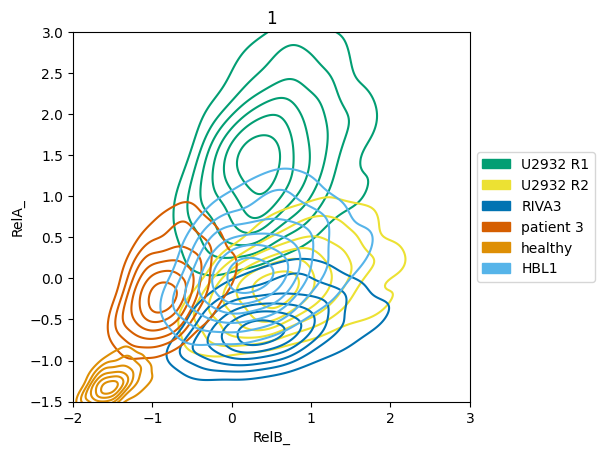

In [18]:
conditionsToPlot=["U2932R1_hiBasal3_ikkOnly","U2932R2_hiBasal3_ikkOnly","Riva3","patient old graph 2","healthy B cells","HBL1"]
theseLegendEntries=["U2932 R1","U2932 R2","RIVA3","patient 3","healthy","HBL1"]
thisColorArray=[colorArray[3],colorArray[9],colorArray[1],colorArray[4],colorArray[2],colorArray[10]]
plotFingersprints("outputsNew",conditionsToPlot,"RelB_","RelA_",thisColorArray,1,last_cell,[-2,3],[-1.5,3],theseLegendEntries);
